# Crypto Pairs Trading Strategy

#### This notebook investigates a mean-reversion pairs trading strategy between ARBUSDT and ATOMUSDT, using historical data from Binance. The goal is to identify statistical relationships, construct a trading signal based on deviations from equilibrium, and assess the strategy's profitability relative to a benchmark.

### 1. Imports and Setup

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from binance.client import Client as bnb_client
import statsmodels.api as sm
from pytrends.request import TrendReq

#### Connect to Binance API and Retrieve Available Symbols

In [61]:
client = bnb_client(tld='US')  # For US users

info = client.get_exchange_info()
symbols = [s['symbol'] for s in info['symbols']]

univ1 = ['MATICUSDT', 'SOLUSDT', 'AVAXUSDT', 'LINKUSDT', 'AAVEUSDT', 'UNIUSDT', 'SUSHIUSDT']
univ2 = ['NEARUSDT', 'APTUSDT', 'ARBUSDT', 'OPUSDT']
univ3 = ['ATOMUSDT', 'DOGEUSDT', 'LTCUSDT', 'DOTUSDT']

In [62]:
def get_binance_px(symbol, freq, start_ts='2021-01-01', end_ts=None):
    data = client.get_historical_klines(symbol, freq, start_ts, end_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 
               'quote_volume', 'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    
    df = pd.DataFrame(data, columns=columns)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    return df

In [63]:
universe = univ1 + univ2 + univ3
freq = '1d'

px, q = {}, {}

In [64]:
for sym in universe:
    data = get_binance_px(sym, freq)
    px[sym] = data.set_index('open_time')['close']
    q[sym] = data.set_index('open_time')['volume']

In [65]:
# Align time indices
start_date = min(s.index.min() for s in px.values())
end_date = max(s.index.max() for s in px.values())
date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

px = pd.DataFrame(px).astype(float).reindex(date_range)
q = pd.DataFrame(q).astype(float).reindex(date_range)
ret = px.pct_change()

 ### 2. Visualize Normalized Prices and Correlation Heatmap


<Axes: title={'center': 'Normalized Prices'}>

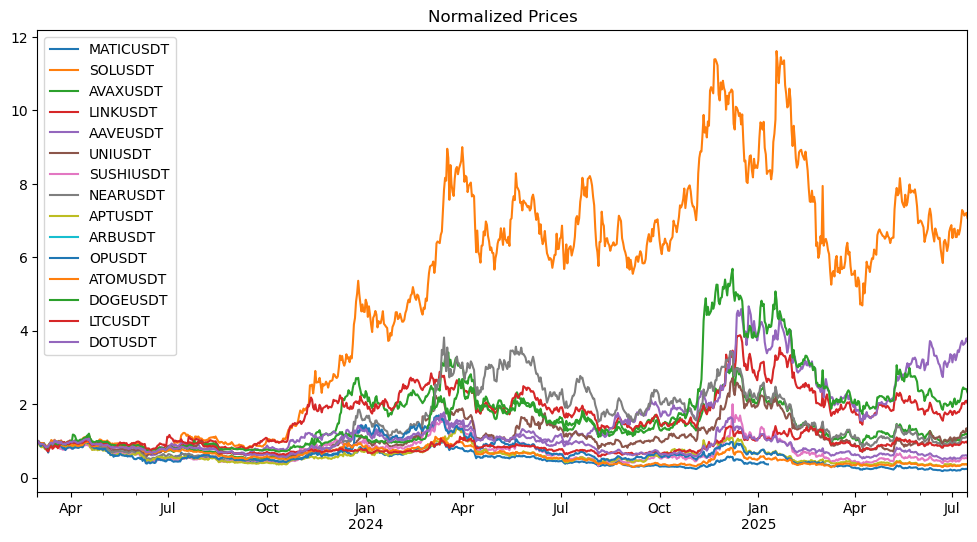

In [66]:
px_after_2022 = px.loc['2023-03-01':]

(px_after_2022 / px_after_2022.iloc[0]).plot(figsize=(12, 6), title='Normalized Prices')

##### While plotting normalized prices over time gives a high-level view of asset movements, it becomes **difficult to discern meaningful relationships** between assets when many are plotted together. To uncover deeper statistical relationships, we turn to **pair-wise correlation analysis**, which quantifies the linear dependency between asset returns.

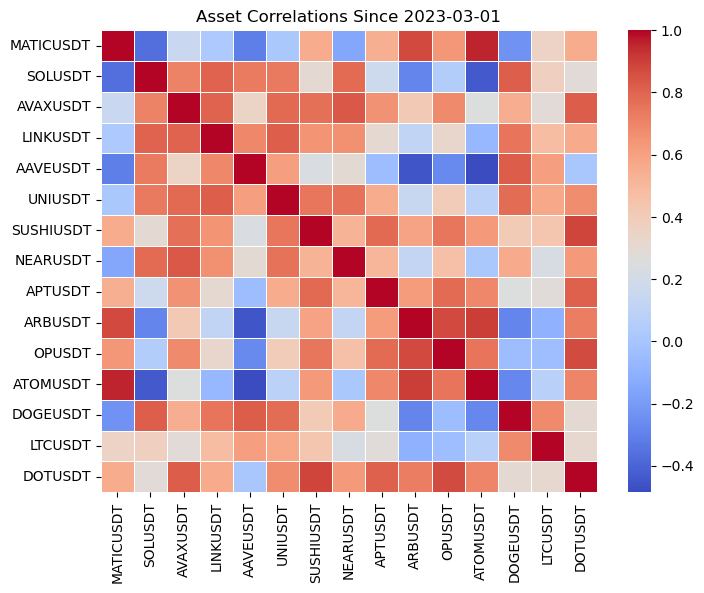

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(px_after_2022.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Asset Correlations Since 2023-03-01")
plt.show()

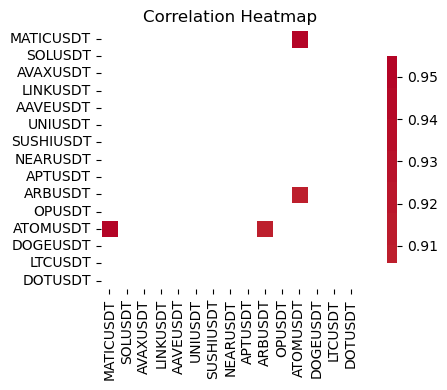

In [68]:
corr = px_after_2022.corr()

plt.figure(figsize=(6, 4))

mask = (corr <= 0.9) | (np.eye(corr.shape[0], dtype=bool))

sns.heatmap(corr, 
            annot=False,  
            mask=mask,   
            fmt=".2f",       
            cmap='coolwarm', 
            center=0,       
            square=True,  
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8})  
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

##### To identify strong co-movement candidates, we plot the **pair-wise correlation matrix** for all assets' pirces and filter for **correlations above 0.90**

##### Among the highlighted pairs, **ARBUSDT** and **ATOMUSDT** stand out due to their strong correlation. This makes them a promising candidate for pairs trading based on **mean-reverting spread behavior**. To further investigate the selected pair, we plot their **normalized price series** to visually assess co-movement and divergence patterns.


### 3. Explore Candidate Pair: ARBUSDT vs ATOMUSDT

<Axes: title={'center': 'Normalized Prices of Pair'}>

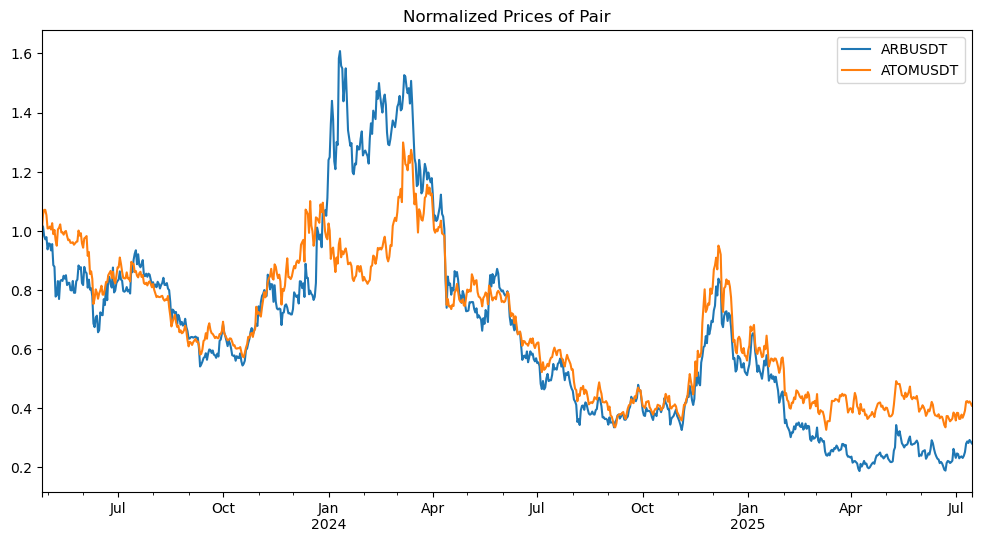

In [69]:
pair = ['ARBUSDT', 'ATOMUSDT']
df_pair = px_after_2022[pair].dropna()
(df_pair / df_pair.iloc[0]).plot(figsize=(12, 6), title="Normalized Prices of Pair")

##### Key divergence-convergence episodes:
##### - **May-June 2023**: The prices diverge noticeably, with ARBUSDT dropping while ATOMUSDT holds up. This divergence later **closes**, creating a profitable reversion opportunity.
##### - **January–March 2024**: Another clear divergence occurs, again followed by re-alignment — suggesting **statistical arbitrage opportunities**.
##### These price dynamics motivate formal modeling of the **spread and z-score** to **generate long-short trading signals**.


### 4. Signal Construction

#### Run Linear Regression Model on Log Prices

                            OLS Regression Results                            
Dep. Variable:               ATOMUSDT   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     6298.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        23:00:32   Log-Likelihood:                 574.82
No. Observations:                 812   AIC:                            -1146.
Df Residuals:                     810   BIC:                            -1136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0687      0.005    457.426      0.0

<Axes: >

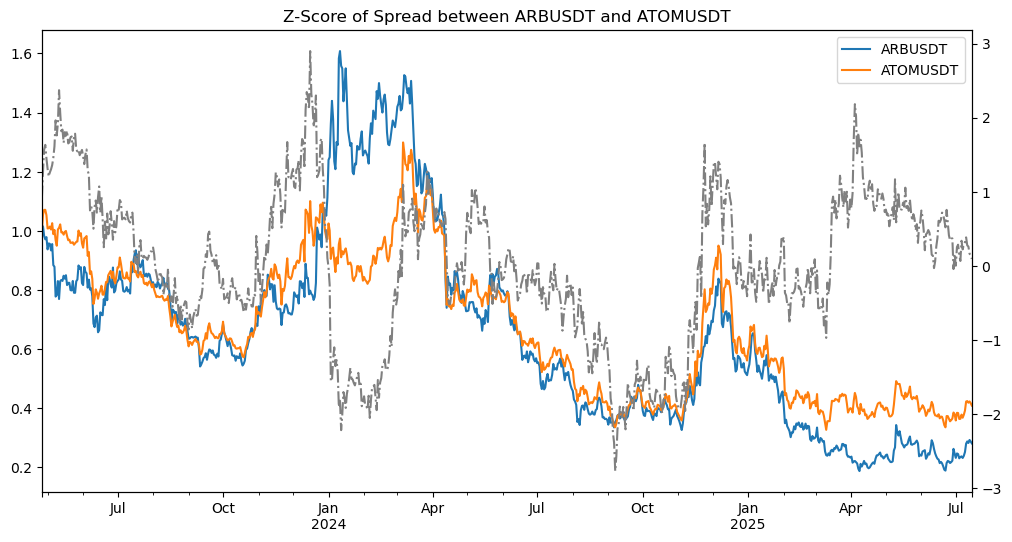

In [70]:
log_px = np.log(df_pair)
X = sm.add_constant(log_px['ARBUSDT'])
y = log_px['ATOMUSDT']

model = sm.OLS(y, X).fit()
print(model.summary())

alpha, beta = model.params['const'], model.params['ARBUSDT']
spread = log_px['ATOMUSDT'] - (alpha + beta * log_px['ARBUSDT'])
z_score = (spread - spread.mean()) / spread.std()
(df_pair / df_pair.iloc[0]).plot(figsize=(12, 6), title="Normalized Prices of Pair")
z_score.plot(figsize=(12, 6), style = '-.',title='Z-Score of Spread between ARBUSDT and ATOMUSDT', secondary_y=True, color = "gray")

##### To formalize the divergence between the two assets, we compute the **spread** as the residual from a linear regression using log prices. We then standardize this spread into a **z-score**, plotted above as the **dotted gray line**.
##### **Insight**:
##### - The z-score indicates how many standard deviations the spread is from its historical mean.
##### - When the z-score is **above +1.5**, ARBUSDT is relatively expensive compared to ATOMUSDT — a potential **short ARB / long ATOM** setup.
##### - When the z-score is **below –1.5**, ARBUSDT is relatively cheap — a potential **long ARB / short ATOM** opportunity.

##### **Price Context**:
##### - The solid lines show the actual normalized price series of ARBUSDT and ATOMUSDT.
##### - Periods where the z-score hits extreme levels (±1.5 to ±2.5) often coincide with **visibly diverging prices**, validating the statistical signal.


#### Signal Generation Based on Z-Score and Return Differential

In [71]:
X_days = 5
ret_diff = df_pair["ARBUSDT"].pct_change(X_days) - df_pair["ATOMUSDT"].pct_change(X_days)

z_thresh = 1.5
ret_thresh = 0.03

long_entry  = (z_score < -z_thresh) & (ret_diff < -ret_thresh)
short_entry = (z_score >  z_thresh) & (ret_diff >  ret_thresh)
exit_signal = z_score.abs() < 0.5

#### **Signal Conditions**:
##### Long Entry:

- ##### `z_score< -1.5`: ATOM is undervalued, ARB is overvalued.

- ##### `ret_diff < -0.03`: ARB has also underperformed by at least 3% in the past 5 days.

##### Short Entry:

- ##### `z_score > 1.5`: ATOM is overvalued, ARB is undervalued.

- ##### `ret_diff > 0.03`: ARB has also outperformed by at least 3% in the past 5 days.

##### Exit Entry:

- ##### `z_score.abs() < 0.5`: The spread has reverted toward equilibrium, so we close the position.

##### In sum, when the normalized **prices of ARBUSDT and ATOMUSDT diverge**, and the **z-score** exceeds thresholds (e.g., ±1.5), the strategy **enters a position** expecting mean reversion.


#### Define Positioning

In [72]:
position = pd.Series(index=z_score.index, dtype=float)
position[long_entry]  = 1    # Long ATOM, Short ARB
position[short_entry] = -1   # Long ARB, Short ATOM
position[exit_signal] = 0
position = position.ffill().fillna(0)

### 5. Backtest: Compute Strategy Returns

<Axes: >

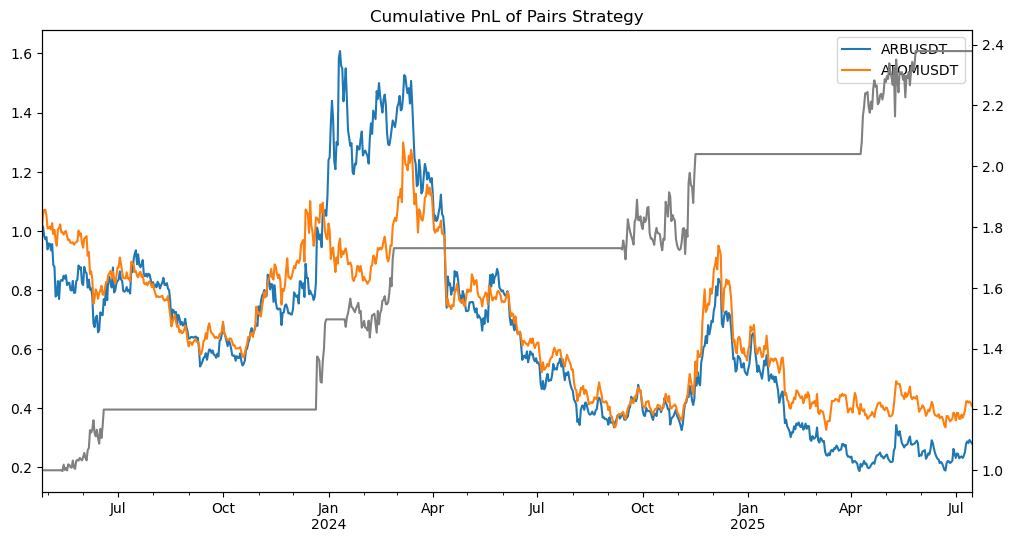

In [73]:
ret_arb = df_pair['ARBUSDT'].pct_change()
ret_atom = df_pair['ATOMUSDT'].pct_change()
strategy_ret = position.shift(1) * (ret_atom - ret_arb * beta)

strategy_cum = (1 + strategy_ret.fillna(0)).cumprod()
(df_pair / df_pair.iloc[0]).plot(figsize=(12, 6), title="Normalized Prices of Pair")
strategy_cum.plot(title="Cumulative PnL of Pairs Strategy", figsize=(12, 6), secondary_y=True, color = "gray")

#### **Observation:**
- ##### During periods of **visible divergence**, the strategy enters.
- ##### When the prices **re-align**, the strategy exits with profit — evident as sharp **upward steps in cumulative PnL** (gray line).


#### Strategy return, volatility and Sharpe

In [74]:
strategy_ann_ret = strategy_ret.mean() * 365
strategy_ann_vol = strategy_ret.std() * np.sqrt(365)

In [75]:
sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(365)
print(f"Sharpe Ratio: {sharpe:.2f}")

Sharpe Ratio: 1.69


#### Benchmark: Buy-and-Hold Strategy

In [76]:
buy_hold_ret = (ret_arb + ret_atom) / 2
buy_hold_cum = (1 + buy_hold_ret.fillna(0)).cumprod()
# buy_hold_cum.plot(title="Buy and Hold Strategy", figsize=(12, 6))
buy_hold_sharpe = buy_hold_ret.mean() / buy_hold_ret.std() * np.sqrt(365)
print(f"Buy and Hold Sharpe Ratio: {buy_hold_sharpe:.2f}")
print(f"Strategy vs Buy-Hold Correlation:, {strategy_ret.corr(buy_hold_ret):.3f}")



Buy and Hold Sharpe Ratio: -0.15
Strategy vs Buy-Hold Correlation:, 0.120


### Add Execution Costs and Evaluate Net Returns

In [77]:
trade_signal = position != position.shift(1)
execution_cost = trade_signal.astype(float) * 0.0020  # 20bps cost
strategy_ret_net = strategy_ret - execution_cost

In [78]:
sharpe_net = strategy_ret_net.mean() / strategy_ret_net.std() * np.sqrt(365)
print(f"Net Sharpe Ratio (after costs): {sharpe_net:.2f}")

Net Sharpe Ratio (after costs): 1.66


### 5. Performance Evaluation

#### Compute Information Ratio and Max Drawdown

In [79]:
active_ret = strategy_ret_net - buy_hold_ret
info_ratio = active_ret.mean() / active_ret.std() * np.sqrt(365)
print(f"Information Ratio: {info_ratio:.2f}")

cum_pnl = (strategy_ret_net.fillna(0) + 1).cumprod()
max_drawdown = ((cum_pnl - cum_pnl.cummax()) / cum_pnl.cummax()).min()
print(f"Max Drawdown: {max_drawdown:.2%}")

Information Ratio: 0.67
Max Drawdown: -10.62%


#### Compute alpha and beta

In [80]:
regression_df = pd.DataFrame({
    'strategy': strategy_ret_net,
    'benchmark': buy_hold_ret
}).dropna()

X = sm.add_constant(regression_df["benchmark"])     # market: buy and hold return
y = regression_df["strategy"]                       # y: strategy returns

model_alpha_beta = sm.OLS(y, X).fit()
# print(model_alpha_beta.summary())

alpha = model_alpha_beta.params['const']
beta = model_alpha_beta.params['benchmark']
print(f"Annualized Alpha: {alpha * 365:.2%}, Beta: {beta:.3f}")

Annualized Alpha: 41.56%, Beta: 0.037


In [82]:
metrics_df = pd.DataFrame([{
    'Annualized Return': strategy_ann_ret,
    'Annualized Volatility': strategy_ann_vol,
    'Sharpe Ratio': sharpe,
    'Net Sharpe Ratio': sharpe_net,
    'Information Ratio': info_ratio,
    'Max Drawdown': max_drawdown,
    'Alpha (daily)': alpha,
    'Beta': beta
}])
metrics_df.T

,0
Annualized Return,0.420130
Annualized Volatility,0.248234
Sharpe Ratio,1.692473
Net Sharpe Ratio,1.658874
Information Ratio,0.665250
Max Drawdown,-0.106155
Alpha (daily),0.001139
Beta,0.037232


#### Performance Summary of the Pairs Trading Strategy (ARB vs. ATOM)

#### Sharpe Ratio (Net: 1.66) 
- Even after trading costs, the simple strategy achieves a Sharpe above 1.5
- Suggests a very efficient use of risk, generating steady returns from relative mispricings

#### Alpha (0.11% daily)	
- This is daily return not explained by market movements
- Annualized, this is 30+% from the strategy’s alpha edge

#### Beta (0.037)
- Shows low correlation to the benchmark returns – the strategy’s returns are largely independent of the paired assets' combined movement
- Confirms that the strategy does not rely on general up or down market trends

### 6. Conclusion

##### In sum, this project validates that **systematic arbitrage models can extract alpha** from noisy crypto markets by leveraging relative pricing inefficiencies — all without needing to predict overall market direction.
##### As a natural extension, we’ll document the use of **multiple high-correlation pairs** in the next project. Trading across pairs helps smooth performance and reduce idiosyncratic risk — pushing the strategy toward a more robust portfolio construction